# Concrete Cracking Detection

In [2]:
#import Required Modules

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report

Labelling the Dataset

In [54]:
#As the Dataset is Unlabeled we need to do the labelling for further process...

In [3]:
positive_dir = Path('./Crack-dataset/Positive')    #naming the positive directory
negative_dir = Path('./Crack-dataset/Negative')    #naming the negative directory

In [4]:
def generate_df(image_dir, label):        #create a dataframe
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath', dtype=pd.StringDtype())   #list all the filepath
    labels = pd.Series(label, name='Label', index=filepaths.index)   #labels for the filepath
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [6]:
positive_da = generate_df(positive_dir, label="POSITIVE")   #assign positive label 
negative_da = generate_df(negative_dir, label="NEGATIVE")   #assign negative label

all_da = pd.concat([positive_da, negative_da], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_da

,Filepath,Label
0,Crack-dataset\Negative\DJI_0670_6_3.jpg,NEGATIVE
1,Crack-dataset\Negative\IMG_2920_6_6.jpg,NEGATIVE
2,Crack-dataset\Positive\IMG_9676_9_10.jpg,POSITIVE
3,Crack-dataset\Positive\IMG_9224_4_8.jpg,POSITIVE
4,Crack-dataset\Positive\IMG_3051_12_2.jpg,POSITIVE
...,...,...
995,Crack-dataset\Negative\IMG_2626_8_8.jpg,NEGATIVE
996,Crack-dataset\Positive\DJI_0781_14_19.jpg,POSITIVE
997,Crack-dataset\Negative\IMG_9603_10_14.jpg,NEGATIVE
998,Crack-dataset\Positive\IMG_2957_3_12.jpg,POSITIVE


Exploratory Data Analysis

In [7]:
#defining some constant values
BATCH_SIZE = 32     
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=60   #epoch is the one entire passing of training data into the algorithm

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(     #load the image from the directory 
    "Crack-dataset",                                               #name of the dataset
    seed=123,
    shuffle=True,                                                  #Shuffle the images randomly
    image_size=(IMAGE_SIZE,IMAGE_SIZE),                            #calling the image size
    batch_size=BATCH_SIZE                                          #calling the bacth size
)

Found 1000 files belonging to 2 classes.


In [9]:
class_names = dataset.class_names        #find the name of two class
class_names

['Negative', 'Positive']

In [10]:
len(dataset)  #length of the dataset after batching here all batch = 32 files, last batch will have 8files

32

In [11]:
for image_batch, label_batch in dataset.take(1): #here take one batch to find the batch size, image size, rgb channel value
    print(image_batch.shape)                     #show (no. of files,image size,rgb value)
    print(label_batch.numpy())                   #display in numpy array of labels in the batch
    
# labels of the class

(32, 224, 224, 3)
[0 1 0 0 0 0 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1]


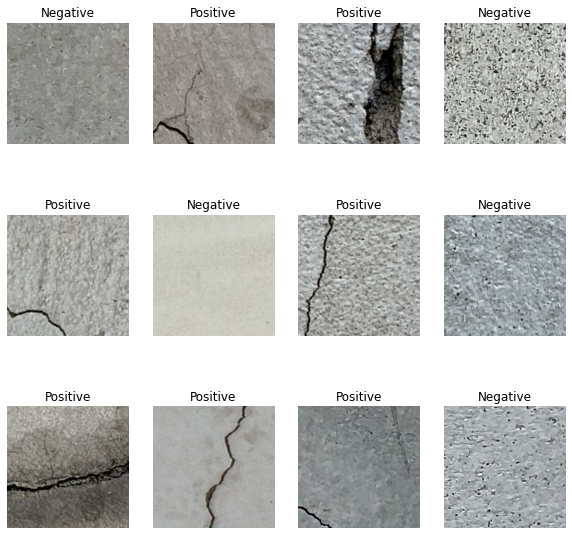

In [12]:
#display 12 images
plt.figure(figsize=(10, 10))  #image dimension in subplot

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)  #create subplot of 3*4 matrix
        plt.imshow(image_batch[i].numpy().astype("uint8"))  
        plt.title(class_names[label_batch[i]])   
        plt.axis("off")    

Train-Test Split

In [13]:
# Here 80% of data is used for Training 
# 10% = validation
# 10% = testing

In [14]:
#A simple code for train test-split using a function

def get_dataset_partition_tf(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, test_ds, val_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [16]:
len(train_ds)   #train_split

25

In [17]:
len(test_ds)    #test_split

3

In [18]:
len(val_ds)     #val_split

4

Catch, Prefetch and Shuffle data

In [19]:
# This is basically done to make the model to perform better in the system
# "Cache" will cache the dataset and store it in memory during one epoch and it will reuse the data for next epoch
# "Prefetch" will load the next data when the 1st training is performing. This will save the time.
# Here buffer_size is automatically done by tensor

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#Here the Data is optimized for training

In [20]:
#Image resizing and rescaling
#This is one of the Layer of Model

rescale_and_resize = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE), #Img is resize when a input img is not in the required size during the use of app
    layers.experimental.preprocessing.Rescaling(1.0/255) #Rescaling is done reduce the numpy array of RGB value to 0 to 1
]) 

Data Augmentation

In [21]:
# This is done to Augment the image for better performence when the input is in any form

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

Model Building

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    rescale_and_resize,  #adding this layer
    layers.Conv2D(16, kernel_size = (3,3), activation='relu'), #12=filters
    layers.MaxPooling2D((2, 2)),   #perform pooling
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape = input_shape), #32=filters
    layers.MaxPooling2D((2,2)),   
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),  #64 filters
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),    #flatten the last pooling layer
    layers.Dense(64, activation='relu'),  #relu is an activation which is used for better performance
    layers.Dense(n_classes, activation='softmax'), #softmax normalize the probability of the classes
])

model.build(input_shape = input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 111, 111, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 54, 54, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 52, 52, 64)         

Compiling the Model

In [23]:
#compile 
model.compile(
    optimizer='adam',   #add adam optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),   #define the loss function
    metrics=['accuracy']    #add the metrics
)

Training the Model

In [24]:
#train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/60
25/25 [==============================] - 17s 562ms/step - loss: 0.6929 - accuracy: 0.4888 - val_loss: 0.7083 - val_accuracy: 0.4219
Epoch 2/60
25/25 [==============================] - 12s 498ms/step - loss: 0.6783 - accuracy: 0.5688 - val_loss: 0.5643 - val_accuracy: 0.7500
Epoch 3/60
25/25 [==============================] - 13s 500ms/step - loss: 0.5366 - accuracy: 0.7462 - val_loss: 0.4730 - val_accuracy: 0.7500
Epoch 4/60
25/25 [==============================] - 12s 496ms/step - loss: 0.5787 - accuracy: 0.7125 - val_loss: 0.5010 - val_accuracy: 0.7500
Epoch 5/60
25/25 [==============================] - 12s 497ms/step - loss: 0.5239 - accuracy: 0.7850 - val_loss: 0.5899 - val_accuracy: 0.6406
Epoch 6/60
25/25 [==============================] - 13s 503ms/step - loss: 0.5238 - accuracy: 0.7350 - val_loss: 0.4781 - val_accuracy: 0.7500
Epoch 7/60
25/25 [==============================] - 13s 502ms/step - loss: 0.4568 - accuracy: 0.8100 - val_loss: 0.5201 - val_accuracy: 0.7031

Epoch 58/60
25/25 [==============================] - 14s 561ms/step - loss: 0.0089 - accuracy: 0.9975 - val_loss: 0.0190 - val_accuracy: 0.9922
Epoch 59/60
25/25 [==============================] - 14s 544ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.0206 - val_accuracy: 0.9922
Epoch 60/60
25/25 [==============================] - 14s 555ms/step - loss: 0.0037 - accuracy: 0.9987 - val_loss: 0.0331 - val_accuracy: 0.9922


In [25]:
scores = model.evaluate(test_ds)  #get the evaluation score

3/3 [==============================] - 1s 135ms/step - loss: 0.0375 - accuracy: 0.9896


In [26]:
scores

[0.0375138483941555, 0.9895833134651184]

In [31]:
#Get all the data from training model

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

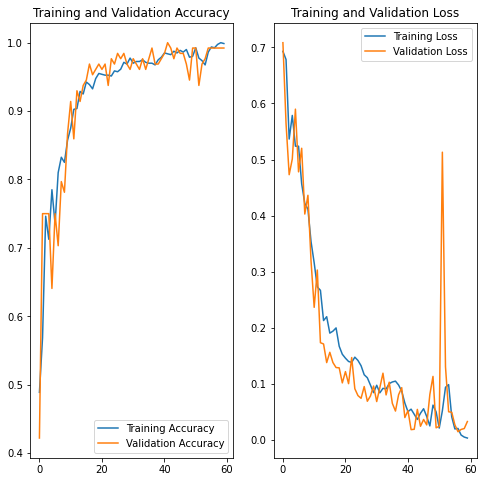

In [32]:
#plot training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#plot training and valiadtion loss
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model Prediction

first image to predict
actual label: Positive
1/1 [==============================] - 0s 485ms/step
predicted label: Positive


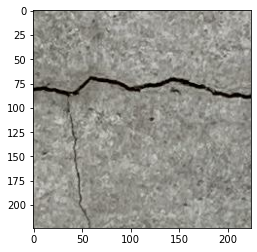

In [33]:
#predict crack

import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [34]:
#create a predict function to predict the crack with its confidence value

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]   #predict crack
    confidence = round(100 * (np.max(predictions[0])), 2)      #calculate confidence
    return predicted_class, confidence

1/1 [==============================] - 0s 48ms/step


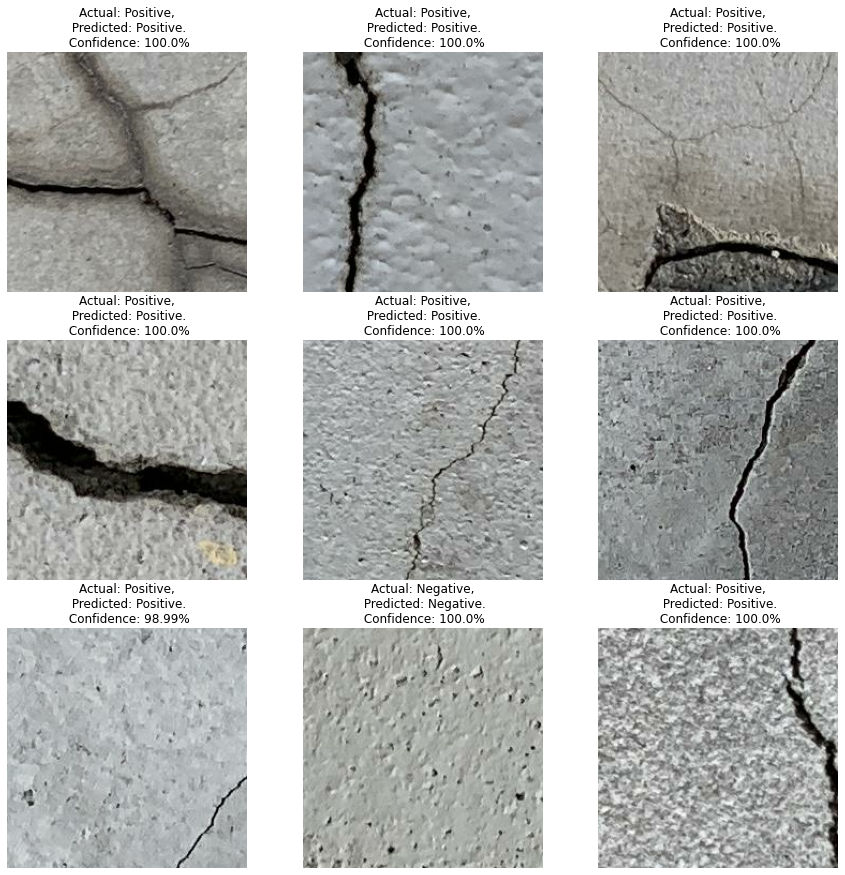

In [35]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [53]:
#perform prediction on test data
y_pred = model.predict(test_ds)

3/3 [==============================] - 0s 134ms/step


In [46]:
#get the prediction values from test data
predicted_categories = tf.argmax(y_pred, axis=1)
predicted_categories

<tf.Tensor: shape=(96,), dtype=int64, numpy=
array([1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0], dtype=int64)>

In [47]:
#get the actual values from test data
true_categories = tf.concat([y for x, y in test_ds], axis=0)
true_categories

<tf.Tensor: shape=(96,), dtype=int32, numpy=
array([1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0])>

Model Evaluation

In [48]:
#evaluate the model

def evaluate_model(model, test_ds):
    
    results = model.evaluate(test_ds, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("Test Loss    : {:.5f}".format(loss))  #print test loss
    print("Test Accuracy: {:.2f}%".format(acc * 100))  #print test accuracy
    
    clr = classification_report(true_categories, predicted_categories, target_names=["NEGATIVE", "POSITIVE"]) 
    
    
    print("Classification Report:\n----------------------\n", clr)

In [49]:
evaluate_model(model, test_ds)

Test Loss    : 0.03751
Test Accuracy: 98.96%
Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       1.00      0.97      0.99        37
    POSITIVE       0.98      1.00      0.99        59

    accuracy                           0.99        96
   macro avg       0.99      0.99      0.99        96
weighted avg       0.99      0.99      0.99        96

